In [8]:
cd '/content/drive/MyDrive/LibriSpeech'

/content/drive/MyDrive/LibriSpeech


In [ ]:
!pip install torchaudio
!apt-get -qq install -y sox

In [28]:
import os
import random
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import sox

import torchaudio
import torch

import itertools

In [14]:
dataFiles = []
root = './train-clean-100/'

#took only 42 speakers for faster processing
subPaths = [v+"/" for v in os.listdir(root) if v[0] != "."][:42]  
for subPath in subPaths:
    subPath2 = [v for v in os.listdir(root+subPath) if v[0] != "."]
    for sb in subPath2:
      files = [v for v in os.listdir(root+subPath+sb) if v[0] != "." and '.flac' in v]
      for file in files:
        #print(os.path.join(root,subPath,sb,file))
        signal, sr = librosa.load(os.path.join(root,subPath,sb,file), sr=16000)
        duration = len(signal)*1./sr
        if duration >= 3:
          dataFiles.append(os.path.join(root,subPath,sb,file))
    print(subPath)

103/
1081/
1069/
1040/
1034/
118/
1098/
1116/
1183/
1088/
1263/
1235/
1334/
125/
1246/
1363/
1355/
1447/
1455/
150/
1594/
1502/
1553/
1578/
1624/
1841/
1723/
163/
1737/
1743/
196/
1926/
19/
1898/
1867/
1963/
198/
200/
1992/
1970/
2007/
2002/


In [15]:
print(len(dataFiles))
head, tail = os.path.split(dataFiles[0])
print(tail)
print(dataFiles[0])

4652
103-1241-0019.flac
./train-clean-100/103/1241/103-1241-0019.flac


In [16]:
chunks = []
names = []

for file in dataFiles:
  signal, sr = librosa.load(file, sr=16000)
  duration = len(signal)*1./sr
 
  # Divide audio data into chunks (3 sec)
  numChunks = int(duration/3)
  sizeChunk = int(len(signal)/numChunks)

  for i in range(0,numChunks):    
    chunk = signal[i*sizeChunk:(i+1)*sizeChunk]      # get a chunk 
    head, tail = os.path.split(file)
    chunks.append(chunk)
    names.append(str(i)+'-'+tail)
    print(str(i)+'-'+tail)

Выходные данные были обрезаны до нескольких последних строк (5000).
3-196-122152-0028.flac
4-196-122152-0028.flac
0-196-122152-0030.flac
1-196-122152-0030.flac
2-196-122152-0030.flac
3-196-122152-0030.flac
4-196-122152-0030.flac
0-196-122152-0032.flac
1-196-122152-0032.flac
2-196-122152-0032.flac
3-196-122152-0032.flac
4-196-122152-0032.flac
0-196-122152-0005.flac
1-196-122152-0005.flac
2-196-122152-0005.flac
3-196-122152-0005.flac
4-196-122152-0005.flac
0-196-122152-0016.flac
1-196-122152-0016.flac
2-196-122152-0016.flac
3-196-122152-0016.flac
0-196-122152-0000.flac
1-196-122152-0000.flac
2-196-122152-0000.flac
0-196-122152-0012.flac
1-196-122152-0012.flac
2-196-122152-0012.flac
0-196-122152-0009.flac
1-196-122152-0009.flac
2-196-122152-0009.flac
3-196-122152-0009.flac
4-196-122152-0009.flac
0-196-122152-0027.flac
1-196-122152-0027.flac
2-196-122152-0027.flac
3-196-122152-0027.flac
4-196-122152-0027.flac
0-196-122152-0031.flac
1-196-122152-0031.flac
2-196-122152-0031.flac
3-196-122152

In [17]:
print(len(chunks))
print(len(names))

17369
17369


In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
        header += f' mfcc{i}'
header += ' label'
header = header.split()
print('CSV Header: ', header)
if os.path.exists('train.csv'):
  os.remove('train.csv')
file = open('train.csv', 'w', newline='')
#with file:
writer = csv.writer(file)
writer.writerow(header)

CSV Header:  ['filename', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth', 'rolloff', 'zero_crossing_rate', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'label']


228

In [ ]:
sr = 16000
for chunk, name in zip(chunks, names):
  y, index = librosa.effects.trim(chunk)
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
  rmse = librosa.feature.rms(y=y)
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  zcr = librosa.feature.zero_crossing_rate(y)
  mfcc = librosa.feature.mfcc(y=y, sr=sr)
  to_append = f'{name} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
  for e in mfcc:
    to_append += f' {np.mean(e)}'
  writer.writerow(to_append.split())
  print(name)
print("End of extractWavFeatures")

In [18]:
data = pd.read_csv('train.csv')

In [19]:
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0-103-1241-0019.flac,0.336803,0.024008,2105.344088,1611.143493,3728.042763,0.143205,-300.432312,58.757175,-29.654697,37.959232,-8.719873,-7.511899,-13.196752,-0.051664,0.426716,2.258825,-7.146095,1.453044,-1.983859,2.455176,0.798451,-3.535457,2.768493,7.418849,4.753322,4.866663,NaN
1,0-103-1241-0001.flac,0.314981,0.024381,1772.923168,1564.416339,3292.251276,0.131796,-320.455963,91.990921,-22.827728,6.459373,-6.521104,10.355440,-11.817273,-7.865493,3.697541,5.581058,2.297534,3.118079,0.992526,3.919697,2.148699,-3.032189,3.700601,2.600282,1.696750,-1.165161,NaN
2,1-103-1241-0001.flac,0.339551,0.020210,1869.606674,1555.789750,3309.231505,0.120615,-359.370148,75.673576,-15.426334,41.124054,0.551127,-6.062479,-15.481269,-5.280317,2.200668,0.711310,-0.136764,9.158607,1.621654,4.526181,-1.485347,-0.792589,1.561035,0.477917,2.757957,-1.529342,NaN
3,2-103-1241-0001.flac,0.322514,0.019928,2470.128593,1663.507723,4124.521684,0.188701,-325.422180,50.003944,-5.222354,36.202477,4.277974,-8.967997,-21.155687,0.995568,-1.422406,0.328328,-1.421216,10.649081,0.810371,2.802202,3.775005,-1.634151,-1.382648,1.768050,0.721481,-0.414478,NaN
4,3-103-1241-0001.flac,0.286731,0.020708,2123.333829,1679.642843,3692.044005,0.166903,-351.445435,80.134888,-6.450970,18.219746,9.118293,-6.865648,-16.499395,-12.899236,1.564277,3.965620,-1.294078,9.161974,0.399019,2.590140,4.117060,-2.267274,0.727258,2.693775,-2.237672,1.666409,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17364,0-2002-139469-0012.flac,0.337849,0.059778,1827.576612,1457.013093,3097.615132,0.162063,-272.448120,100.447670,-12.828773,2.254155,-0.113953,-2.232143,-10.571420,-16.825819,-9.422431,-9.256481,-6.997859,-5.777409,-5.440687,2.142224,-2.422778,-6.362248,-3.084206,-1.799128,-7.252750,-5.186006,NaN
17365,1-2002-139469-0012.flac,0.418173,0.045244,2191.333668,1741.594654,3866.694079,0.188045,-311.506073,80.347435,15.606912,-0.946219,-6.977972,-1.299707,-7.937550,-7.821271,-9.339811,-6.196220,-6.611618,-5.381275,-7.024462,5.034063,-2.077923,-2.694631,0.041087,-0.200787,-4.778393,-2.607971,NaN
17366,2-2002-139469-0012.flac,0.385991,0.050222,2161.054303,1679.260301,3760.608553,0.185665,-296.023438,78.061562,10.185519,13.549878,2.428564,-4.534359,-11.247857,-9.490953,-1.480788,-11.268352,-6.992159,-3.961458,-6.432160,3.482906,-3.212990,-4.272471,0.013166,-4.886504,-6.314638,-2.693337,NaN
17367,3-2002-139469-0012.flac,0.389388,0.055544,1832.793645,1557.381459,3268.174342,0.154975,-271.810394,103.432655,6.090001,6.077754,1.675214,0.536603,-12.679377,-10.300508,-7.506723,-8.163033,-9.206614,-4.908015,-5.880413,3.443261,0.589391,-5.112607,-1.897188,-0.038618,-5.737835,-3.652198,NaN


In [20]:
data['label'] = data.apply(lambda x: x['filename'].split('-')[1], axis=1)

In [21]:
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0-103-1241-0019.flac,0.336803,0.024008,2105.344088,1611.143493,3728.042763,0.143205,-300.432312,58.757175,-29.654697,37.959232,-8.719873,-7.511899,-13.196752,-0.051664,0.426716,2.258825,-7.146095,1.453044,-1.983859,2.455176,0.798451,-3.535457,2.768493,7.418849,4.753322,4.866663,103
1,0-103-1241-0001.flac,0.314981,0.024381,1772.923168,1564.416339,3292.251276,0.131796,-320.455963,91.990921,-22.827728,6.459373,-6.521104,10.355440,-11.817273,-7.865493,3.697541,5.581058,2.297534,3.118079,0.992526,3.919697,2.148699,-3.032189,3.700601,2.600282,1.696750,-1.165161,103
2,1-103-1241-0001.flac,0.339551,0.020210,1869.606674,1555.789750,3309.231505,0.120615,-359.370148,75.673576,-15.426334,41.124054,0.551127,-6.062479,-15.481269,-5.280317,2.200668,0.711310,-0.136764,9.158607,1.621654,4.526181,-1.485347,-0.792589,1.561035,0.477917,2.757957,-1.529342,103
3,2-103-1241-0001.flac,0.322514,0.019928,2470.128593,1663.507723,4124.521684,0.188701,-325.422180,50.003944,-5.222354,36.202477,4.277974,-8.967997,-21.155687,0.995568,-1.422406,0.328328,-1.421216,10.649081,0.810371,2.802202,3.775005,-1.634151,-1.382648,1.768050,0.721481,-0.414478,103
4,3-103-1241-0001.flac,0.286731,0.020708,2123.333829,1679.642843,3692.044005,0.166903,-351.445435,80.134888,-6.450970,18.219746,9.118293,-6.865648,-16.499395,-12.899236,1.564277,3.965620,-1.294078,9.161974,0.399019,2.590140,4.117060,-2.267274,0.727258,2.693775,-2.237672,1.666409,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17364,0-2002-139469-0012.flac,0.337849,0.059778,1827.576612,1457.013093,3097.615132,0.162063,-272.448120,100.447670,-12.828773,2.254155,-0.113953,-2.232143,-10.571420,-16.825819,-9.422431,-9.256481,-6.997859,-5.777409,-5.440687,2.142224,-2.422778,-6.362248,-3.084206,-1.799128,-7.252750,-5.186006,2002
17365,1-2002-139469-0012.flac,0.418173,0.045244,2191.333668,1741.594654,3866.694079,0.188045,-311.506073,80.347435,15.606912,-0.946219,-6.977972,-1.299707,-7.937550,-7.821271,-9.339811,-6.196220,-6.611618,-5.381275,-7.024462,5.034063,-2.077923,-2.694631,0.041087,-0.200787,-4.778393,-2.607971,2002
17366,2-2002-139469-0012.flac,0.385991,0.050222,2161.054303,1679.260301,3760.608553,0.185665,-296.023438,78.061562,10.185519,13.549878,2.428564,-4.534359,-11.247857,-9.490953,-1.480788,-11.268352,-6.992159,-3.961458,-6.432160,3.482906,-3.212990,-4.272471,0.013166,-4.886504,-6.314638,-2.693337,2002
17367,3-2002-139469-0012.flac,0.389388,0.055544,1832.793645,1557.381459,3268.174342,0.154975,-271.810394,103.432655,6.090001,6.077754,1.675214,0.536603,-12.679377,-10.300508,-7.506723,-8.163033,-9.206614,-4.908015,-5.880413,3.443261,0.589391,-5.112607,-1.897188,-0.038618,-5.737835,-3.652198,2002


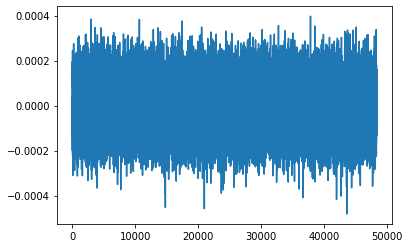

In [ ]:
#noise example
noise=np.random.normal(0, 1e-4, chunks[0].shape[0])
noise
import matplotlib.pyplot as plt
plt.plot(noise)

In [ ]:
#Additive White Gaussian Noise
def AWGN(signal, p):
  std=[1e-4, 1e-3, 1e-2]
  if random.uniform(0, 1) <= p:
    noise = np.random.normal(0, random.choice(std), signal.shape[0])
    signal =  noise + signal
    print('noise')
    return signal
  else: 
    return signal

#Echo delay
def Echo(signal, p):
  delay=[1, 10, 100]
  sample_rate=16000
  gain_in=0.8
  gain_out=0.5
  decay=0.3
  max_len=80000

  if random.uniform(0, 1) <= p:
    tfm = sox.Transformer()
    tfm.echo(gain_in=gain_in, gain_out=gain_out, delays[random.choice(delay)], decays=[decay])
    y_out = tfm.build_array(input_array=signal, sample_rate_in=sample_rate)
    print('echo')
    return y_out
  else:
    return signal



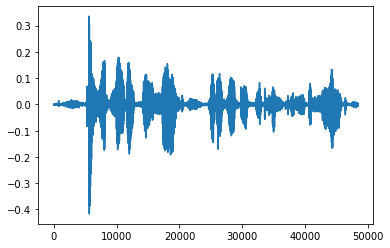

In [ ]:
noise = AWGN(chunks[0], 0.5)
plt.plot(noise)

In [ ]:
y = chunks[0]

In [ ]:
tfm = sox.Transformer()
tfm.echo(delays=[100])
y_out = tfm.build_array(input_array=y, sample_rate_in=16000)


In [ ]:
Audio(y_out, rate=16000)

In [ ]:
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0-103-1241-0019.flac,0.336803,0.024008,2105.344088,1611.143493,3728.042763,0.143205,-300.432312,58.757175,-29.654697,37.959232,-8.719873,-7.511899,-13.196752,-0.051664,0.426716,2.258825,-7.146095,1.453044,-1.983859,2.455176,0.798451,-3.535457,2.768493,7.418849,4.753322,4.866663,103
1,0-103-1241-0001.flac,0.314981,0.024381,1772.923168,1564.416339,3292.251276,0.131796,-320.455963,91.990921,-22.827728,6.459373,-6.521104,10.355440,-11.817273,-7.865493,3.697541,5.581058,2.297534,3.118079,0.992526,3.919697,2.148699,-3.032189,3.700601,2.600282,1.696750,-1.165161,103
2,1-103-1241-0001.flac,0.339551,0.020210,1869.606674,1555.789750,3309.231505,0.120615,-359.370148,75.673576,-15.426334,41.124054,0.551127,-6.062479,-15.481269,-5.280317,2.200668,0.711310,-0.136764,9.158607,1.621654,4.526181,-1.485347,-0.792589,1.561035,0.477917,2.757957,-1.529342,103
3,2-103-1241-0001.flac,0.322514,0.019928,2470.128593,1663.507723,4124.521684,0.188701,-325.422180,50.003944,-5.222354,36.202477,4.277974,-8.967997,-21.155687,0.995568,-1.422406,0.328328,-1.421216,10.649081,0.810371,2.802202,3.775005,-1.634151,-1.382648,1.768050,0.721481,-0.414478,103
4,3-103-1241-0001.flac,0.286731,0.020708,2123.333829,1679.642843,3692.044005,0.166903,-351.445435,80.134888,-6.450970,18.219746,9.118293,-6.865648,-16.499395,-12.899236,1.564277,3.965620,-1.294078,9.161974,0.399019,2.590140,4.117060,-2.267274,0.727258,2.693775,-2.237672,1.666409,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17364,0-2002-139469-0012.flac,0.337849,0.059778,1827.576612,1457.013093,3097.615132,0.162063,-272.448120,100.447670,-12.828773,2.254155,-0.113953,-2.232143,-10.571420,-16.825819,-9.422431,-9.256481,-6.997859,-5.777409,-5.440687,2.142224,-2.422778,-6.362248,-3.084206,-1.799128,-7.252750,-5.186006,2002
17365,1-2002-139469-0012.flac,0.418173,0.045244,2191.333668,1741.594654,3866.694079,0.188045,-311.506073,80.347435,15.606912,-0.946219,-6.977972,-1.299707,-7.937550,-7.821271,-9.339811,-6.196220,-6.611618,-5.381275,-7.024462,5.034063,-2.077923,-2.694631,0.041087,-0.200787,-4.778393,-2.607971,2002
17366,2-2002-139469-0012.flac,0.385991,0.050222,2161.054303,1679.260301,3760.608553,0.185665,-296.023438,78.061562,10.185519,13.549878,2.428564,-4.534359,-11.247857,-9.490953,-1.480788,-11.268352,-6.992159,-3.961458,-6.432160,3.482906,-3.212990,-4.272471,0.013166,-4.886504,-6.314638,-2.693337,2002
17367,3-2002-139469-0012.flac,0.389388,0.055544,1832.793645,1557.381459,3268.174342,0.154975,-271.810394,103.432655,6.090001,6.077754,1.675214,0.536603,-12.679377,-10.300508,-7.506723,-8.163033,-9.206614,-4.908015,-5.880413,3.443261,0.589391,-5.112607,-1.897188,-0.038618,-5.737835,-3.652198,2002


In [22]:
#drop unnecessary columns
train_data1 = data.drop(['filename', 'chroma_stft'], axis=1)
train_data1

,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.024008,2105.344088,1611.143493,3728.042763,0.143205,-300.432312,58.757175,-29.654697,37.959232,-8.719873,-7.511899,-13.196752,-0.051664,0.426716,2.258825,-7.146095,1.453044,-1.983859,2.455176,0.798451,-3.535457,2.768493,7.418849,4.753322,4.866663,103
1,0.024381,1772.923168,1564.416339,3292.251276,0.131796,-320.455963,91.990921,-22.827728,6.459373,-6.521104,10.355440,-11.817273,-7.865493,3.697541,5.581058,2.297534,3.118079,0.992526,3.919697,2.148699,-3.032189,3.700601,2.600282,1.696750,-1.165161,103
2,0.020210,1869.606674,1555.789750,3309.231505,0.120615,-359.370148,75.673576,-15.426334,41.124054,0.551127,-6.062479,-15.481269,-5.280317,2.200668,0.711310,-0.136764,9.158607,1.621654,4.526181,-1.485347,-0.792589,1.561035,0.477917,2.757957,-1.529342,103
3,0.019928,2470.128593,1663.507723,4124.521684,0.188701,-325.422180,50.003944,-5.222354,36.202477,4.277974,-8.967997,-21.155687,0.995568,-1.422406,0.328328,-1.421216,10.649081,0.810371,2.802202,3.775005,-1.634151,-1.382648,1.768050,0.721481,-0.414478,103
4,0.020708,2123.333829,1679.642843,3692.044005,0.166903,-351.445435,80.134888,-6.450970,18.219746,9.118293,-6.865648,-16.499395,-12.899236,1.564277,3.965620,-1.294078,9.161974,0.399019,2.590140,4.117060,-2.267274,0.727258,2.693775,-2.237672,1.666409,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17364,0.059778,1827.576612,1457.013093,3097.615132,0.162063,-272.448120,100.447670,-12.828773,2.254155,-0.113953,-2.232143,-10.571420,-16.825819,-9.422431,-9.256481,-6.997859,-5.777409,-5.440687,2.142224,-2.422778,-6.362248,-3.084206,-1.799128,-7.252750,-5.186006,2002
17365,0.045244,2191.333668,1741.594654,3866.694079,0.188045,-311.506073,80.347435,15.606912,-0.946219,-6.977972,-1.299707,-7.937550,-7.821271,-9.339811,-6.196220,-6.611618,-5.381275,-7.024462,5.034063,-2.077923,-2.694631,0.041087,-0.200787,-4.778393,-2.607971,2002
17366,0.050222,2161.054303,1679.260301,3760.608553,0.185665,-296.023438,78.061562,10.185519,13.549878,2.428564,-4.534359,-11.247857,-9.490953,-1.480788,-11.268352,-6.992159,-3.961458,-6.432160,3.482906,-3.212990,-4.272471,0.013166,-4.886504,-6.314638,-2.693337,2002
17367,0.055544,1832.793645,1557.381459,3268.174342,0.154975,-271.810394,103.432655,6.090001,6.077754,1.675214,0.536603,-12.679377,-10.300508,-7.506723,-8.163033,-9.206614,-4.908015,-5.880413,3.443261,0.589391,-5.112607,-1.897188,-0.038618,-5.737835,-3.652198,2002


In [23]:
train_data1["label"] = train_data1["label"].astype('category')
train_data1["label"] = train_data1["label"].cat.codes

In [24]:
np.unique(train_data1['label']).shape

(42,)

In [25]:
from sklearn.model_selection import train_test_split
X = np.array(train_data1.iloc[:, :-1], dtype = float)
y = np.array(train_data1.iloc[:, -1], dtype = float)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
print(X_train.shape)
print(X_val.shape)

(12158, 25)
(5211, 25)


In [27]:
#Normalizing the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform( X_train )
X_val = scaler.transform( X_val )


In [ ]:
from keras import models
from keras import layers
import keras

# model 1
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(42, activation='softmax'))


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# simple early stopping
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#Train with early stopping to avoid overfitting
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=128, 
                    callbacks=[es])

Epoch 1/50
95/95 [==============================] - 1s 8ms/step - loss: 3.6491 - accuracy: 0.0628 - val_loss: 2.4846 - val_accuracy: 0.5233
Epoch 2/50
95/95 [==============================] - 1s 6ms/step - loss: 2.6574 - accuracy: 0.2709 - val_loss: 1.2467 - val_accuracy: 0.7995
Epoch 3/50
95/95 [==============================] - 1s 6ms/step - loss: 1.9058 - accuracy: 0.4453 - val_loss: 0.7182 - val_accuracy: 0.8929
Epoch 4/50
95/95 [==============================] - 1s 6ms/step - loss: 1.4578 - accuracy: 0.5641 - val_loss: 0.4663 - val_accuracy: 0.9190
Epoch 5/50
95/95 [==============================] - 1s 7ms/step - loss: 1.1853 - accuracy: 0.6382 - val_loss: 0.3510 - val_accuracy: 0.9399
Epoch 6/50
95/95 [==============================] - 1s 6ms/step - loss: 1.0425 - accuracy: 0.6781 - val_loss: 0.2811 - val_accuracy: 0.9457
Epoch 7/50
95/95 [==============================] - 1s 6ms/step - loss: 0.9262 - accuracy: 0.7132 - val_loss: 0.2278 - val_accuracy: 0.9557
Epoch 8/50
95/95 [==